In [1]:
import yfinance as yf

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import csv
import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import math

# import Model
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, TimeDistributed
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

from tensorflow.keras.utils import plot_model

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind

In [2]:
###########LQ45

In [3]:
# Load data
LQ45 = yf.download("^JKLQ45", start= "2000-11-28", end="2024-05-22")
LQ45.head

[*********************100%%**********************]  1 of 1 completed


<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2000-11-28   85.220001   85.220001   84.050003   84.639999   84.639999   
2000-11-29   84.459999   84.459999   83.629997   84.370003   84.370003   
2000-11-30   84.370003   85.489998   84.050003   85.489998   85.489998   
2000-12-01   85.199997   85.199997   84.400002   84.589996   84.589996   
2000-12-04   84.570000   85.949997   84.570000   85.500000   85.500000   
...                ...         ...         ...         ...         ...   
2024-05-15  893.020020  904.780029  890.919983  901.400024  901.400024   
2024-05-16  906.669983  912.590027  904.900024  909.309998  909.309998   
2024-05-17  909.909973  925.640015  909.030029  919.510010  919.510010   
2024-05-20  922.169983  927.979980  905.390015  908.539978  908.539978   
2024-05-21  906.820007  909.830017  890.690002  891.580017  891.580017   

       

In [4]:
# Check missing value
LQ45.isnull().sum()

#cek vol= 0
b = LQ45[LQ45.Volume == 0]
len(b)

614

In [5]:
# Substitute 0 volume with previous day's volume
LQ45['Volume'] = LQ45['Volume'].replace(0, method='ffill')

In [7]:
# get returns from adj_close
adj_close_LQ = LQ45.filter(['Adj Close'])
returns_LQ = adj_close_LQ.pct_change().fillna(0)
returns_LQ.head

<bound method NDFrame.head of             Adj Close
Date                 
2000-11-28   0.000000
2000-11-29  -0.003190
2000-11-30   0.013275
2000-12-01  -0.010528
2000-12-04   0.010758
...               ...
2024-05-15   0.009881
2024-05-16   0.008775
2024-05-17   0.011217
2024-05-20  -0.011930
2024-05-21  -0.018667

[5699 rows x 1 columns]>

In [8]:
# Resample daily returns to weekly returns
LQ45_returns_weekly = returns_LQ.resample('W').sum()

In [9]:
LQ45_returns_weekly.head

<bound method NDFrame.head of             Adj Close
Date                 
2000-12-03  -0.000443
2000-12-10   0.015373
2000-12-17  -0.026885
2000-12-24  -0.034690
2000-12-31   0.000000
...               ...
2024-04-28  -0.023241
2024-05-05   0.005772
2024-05-12  -0.010960
2024-05-19   0.028931
2024-05-26  -0.030598

[1226 rows x 1 columns]>

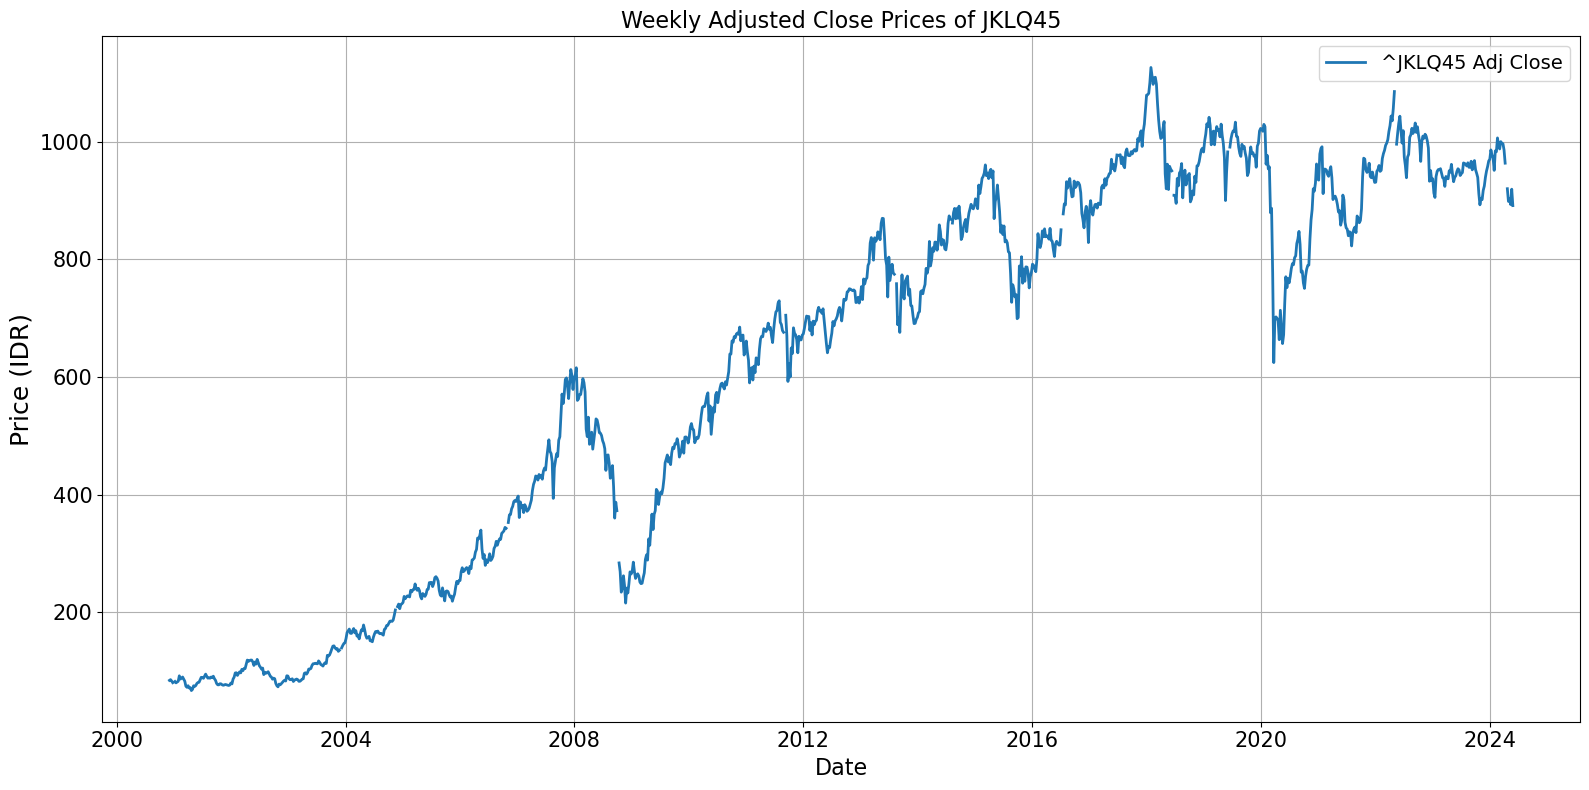

In [10]:
# Plot weekly adjusted close prices of ICBP.JK with larger axis labels and ticks
plt.figure(figsize=(16, 8))  
plt.plot(LQ45_adj_close_weekly, label='^JKLQ45 Adj Close', linewidth=2) 
plt.title('Weekly Adjusted Close Prices of JKLQ45', fontsize=16)  # Increase title font size
plt.xlabel('Date', fontsize=16)  # Increase x-axis label font size
plt.ylabel('Price (IDR)', fontsize=18)  # Increase y-axis label font size
plt.legend(fontsize=14)  # Increase legend font size
plt.grid(True)

# Increase the size of tick labels
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()


In [11]:
########### ICBP

In [12]:
# Load data
ICBP = yf.download("ICBP.JK", start= "2000-11-28", end="2024-05-22")
ICBP.head

[*********************100%%**********************]  1 of 1 completed


<bound method NDFrame.head of                Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2000-11-28    412.5    412.5    400.0    412.5    317.221588  28649000
2000-11-29    412.5    412.5    400.0    412.5    317.221588   4246000
2000-11-30    412.5    412.5    400.0    412.5    317.221588   8145000
2000-12-01    412.5    412.5    400.0    412.5    317.221588   1860000
2000-12-04    412.5    412.5    400.0    412.5    317.221588  21370000
...             ...      ...      ...      ...           ...       ...
2024-05-15  10300.0  10600.0  10175.0  10600.0  10600.000000   5442200
2024-05-16  10700.0  10900.0  10500.0  10575.0  10575.000000   4835200
2024-05-17  10575.0  10750.0  10450.0  10550.0  10550.000000   4102700
2024-05-20  10600.0  10725.0  10450.0  10500.0  10500.000000   2328300
2024-05-21  10550.0  10575.0  10350.0  10400.0  10400.000000   3604100

[5854 rows x 6 columns]>

In [13]:
# Check missing value
ICBP.isnull().sum()

#cek vol= 0
a = ICBP[ICBP.Volume == 0]
len(a)

193

In [14]:
# Substitute 0 volume with previous day's volume
ICBP['Volume'] = ICBP['Volume'].replace(0, method='ffill')

In [15]:
# Resample daily adjusted close prices to weekly adjusted close prices
ICBP_adj_close_weekly = ICBP['Adj Close'].resample('W').last()

In [16]:
# get returns from adj close
adj_close_ICBP = ICBP.filter(['Adj Close'])
returns_ICBP = adj_close_ICBP.pct_change().fillna(0)
returns_ICBP.head

<bound method NDFrame.head of             Adj Close
Date                 
2000-11-28   0.000000
2000-11-29   0.000000
2000-11-30   0.000000
2000-12-01   0.000000
2000-12-04   0.000000
...               ...
2024-05-15   0.029126
2024-05-16  -0.002358
2024-05-17  -0.002364
2024-05-20  -0.004739
2024-05-21  -0.009524

[5854 rows x 1 columns]>

In [17]:
# Resample daily returns to weekly returns
ICBP_returns_weekly = returns_ICBP.resample('W').sum()

In [18]:
ICBP_returns_weekly.head

<bound method NDFrame.head of             Adj Close
Date                 
2000-12-03   0.000000
2000-12-10   0.000891
2000-12-17  -0.029356
2000-12-24  -0.031250
2000-12-31   0.000000
...               ...
2024-04-28   0.087907
2024-05-05   0.024829
2024-05-12  -0.006912
2024-05-19  -0.019680
2024-05-26  -0.014263

[1226 rows x 1 columns]>

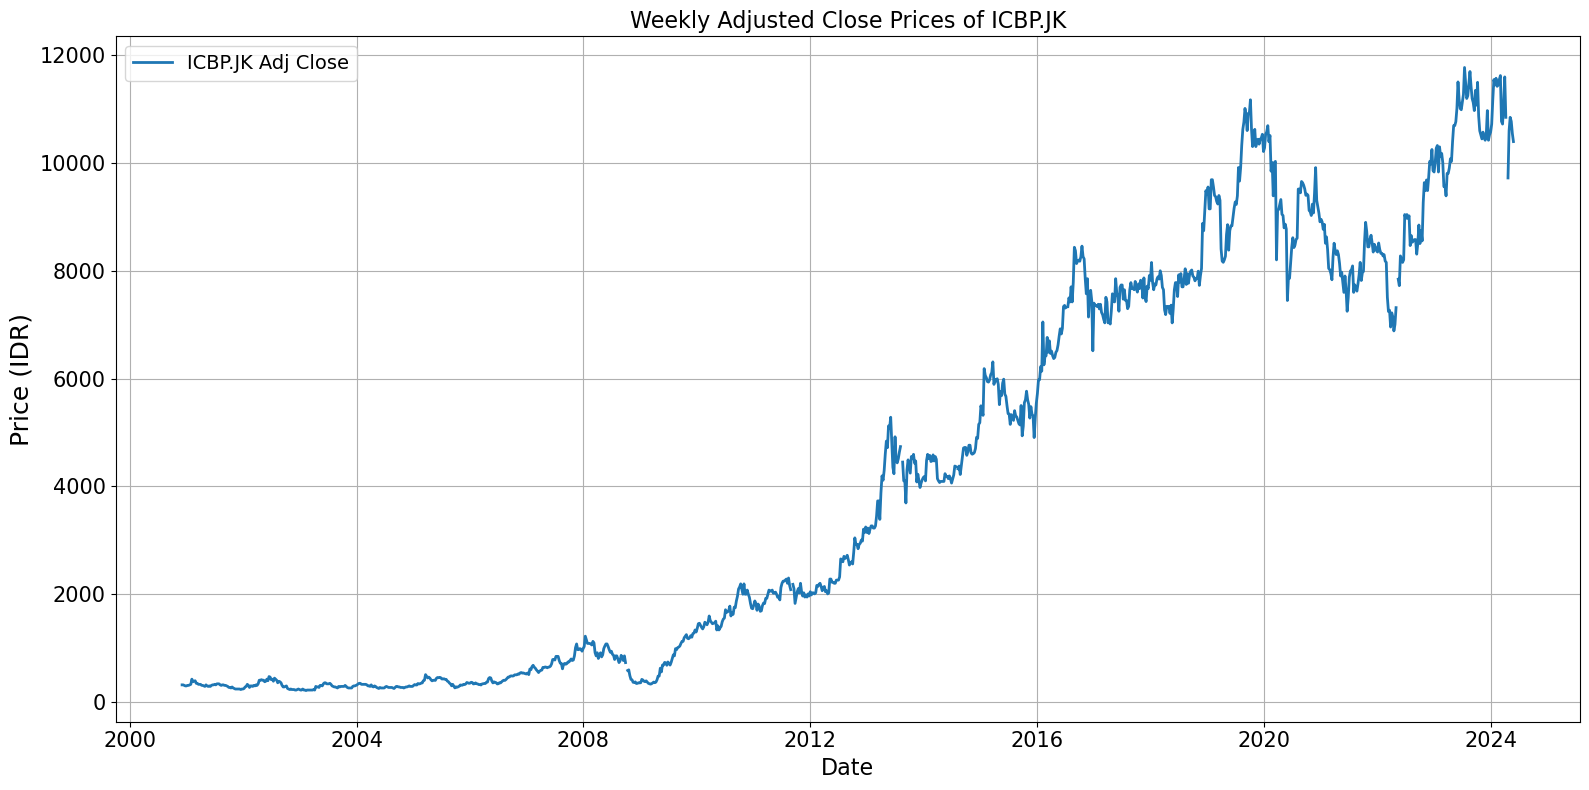

In [19]:
# Plot weekly adjusted close prices of ICBP.JK with larger axis labels and ticks
plt.figure(figsize=(16, 8))  
plt.plot(ICBP_adj_close_weekly, label='ICBP.JK Adj Close', linewidth=2) 
plt.title('Weekly Adjusted Close Prices of ICBP.JK', fontsize=16)  # Increase title font size
plt.xlabel('Date', fontsize=16)  # Increase x-axis label font size
plt.ylabel('Price (IDR)', fontsize=18)  # Increase y-axis label font size
plt.legend(fontsize=14)  # Increase legend font size
plt.grid(True)

# Increase the size of tick labels
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()


In [20]:
########## Both stock

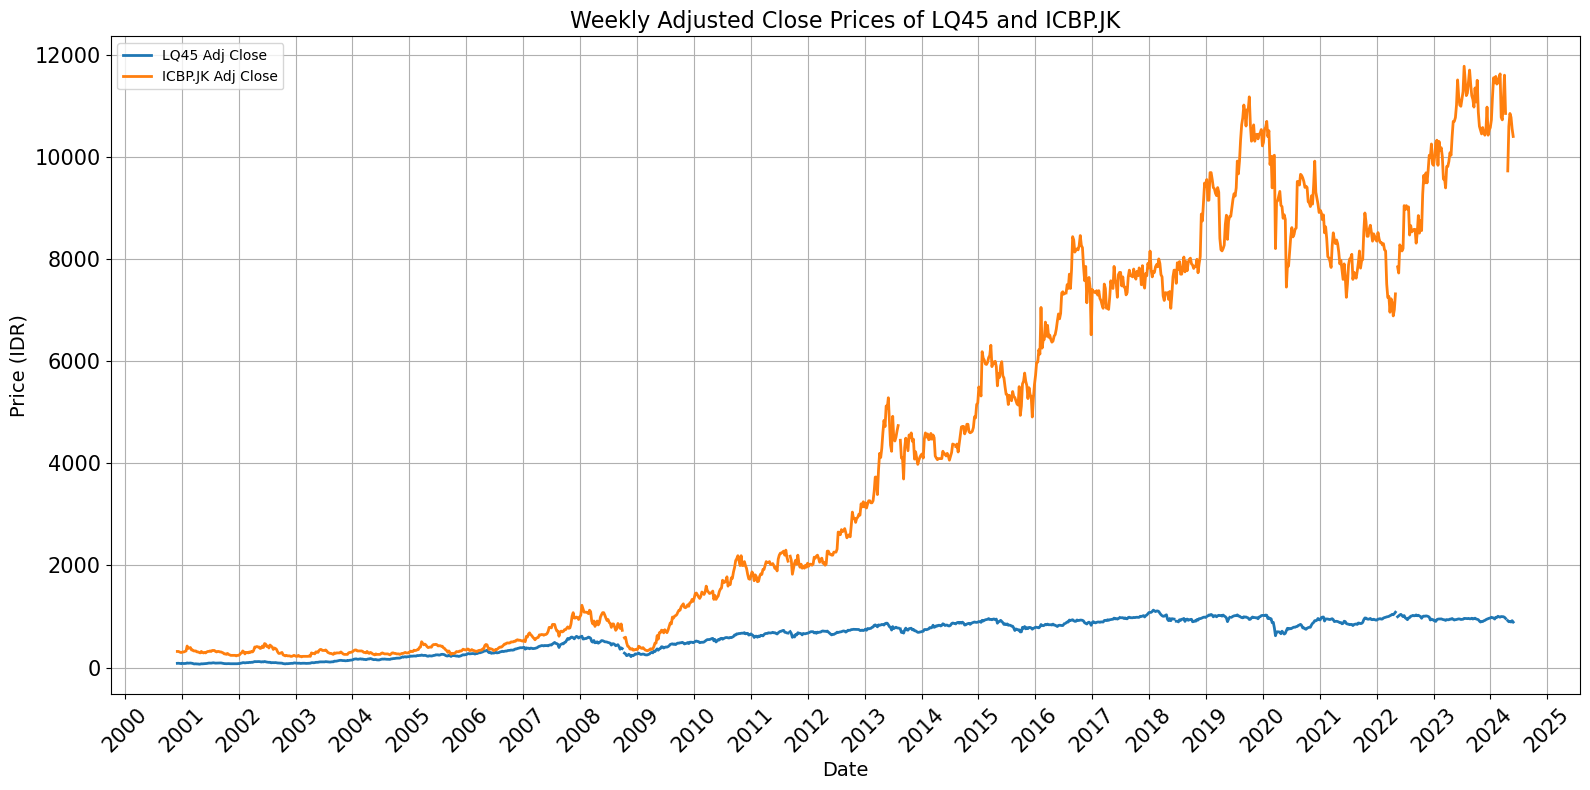

In [21]:
# Plot weekly adjusted close prices of both stocks
plt.figure(figsize=(16, 8))  # Increase figure size for better clarity

# Plot LQ45 and ICBP adjusted close prices
plt.plot(LQ45_adj_close_weekly, label='LQ45 Adj Close', linewidth=2)
plt.plot(ICBP_adj_close_weekly, label='ICBP.JK Adj Close', linewidth=2)

# Set title and labels
plt.title('Weekly Adjusted Close Prices of LQ45 and ICBP.JK', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (IDR)', fontsize=14)

# Set x-ticks to show all years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set the major ticks to be every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the ticks to show only the year

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Increase the size of tick labels
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Show legend and grid
plt.legend()
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()  

# Show plot
plt.show()

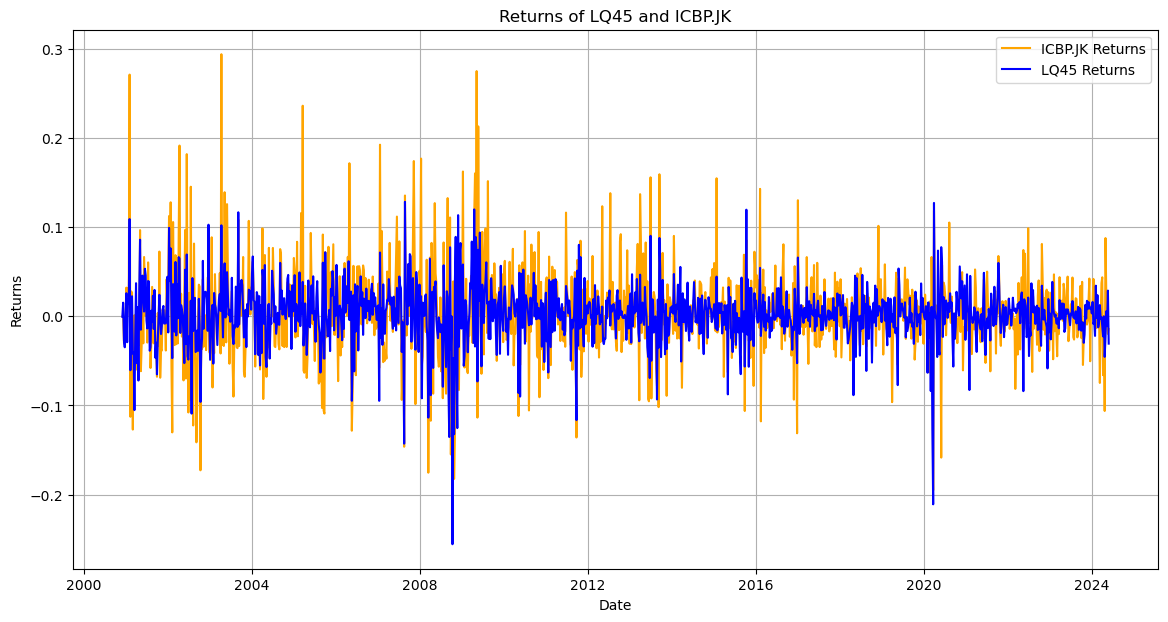

In [22]:
# Plot Returns of both stocks
plt.figure(figsize=(14, 7))

# Plot ICBP returns first to ensure LQ45 is plotted on top
plt.plot(ICBP_returns_weekly, label='ICBP.JK Returns', color='orange')  
plt.plot(LQ45_returns_weekly, label='LQ45 Returns', color='blue')  # Plot LQ45 returns second

plt.title('Returns of LQ45 and ICBP.JK')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Cumulative returns calculation
initial_investment = 1  # Assume $1 investment

# Cumulative returns for LQ45
cumulative_returns_LQ45 = (1 + LQ45_returns_weekly).cumprod() * initial_investment

# Cumulative returns for ICBP
cumulative_returns_ICBP = (1 + ICBP_returns_weekly).cumprod() * initial_investment

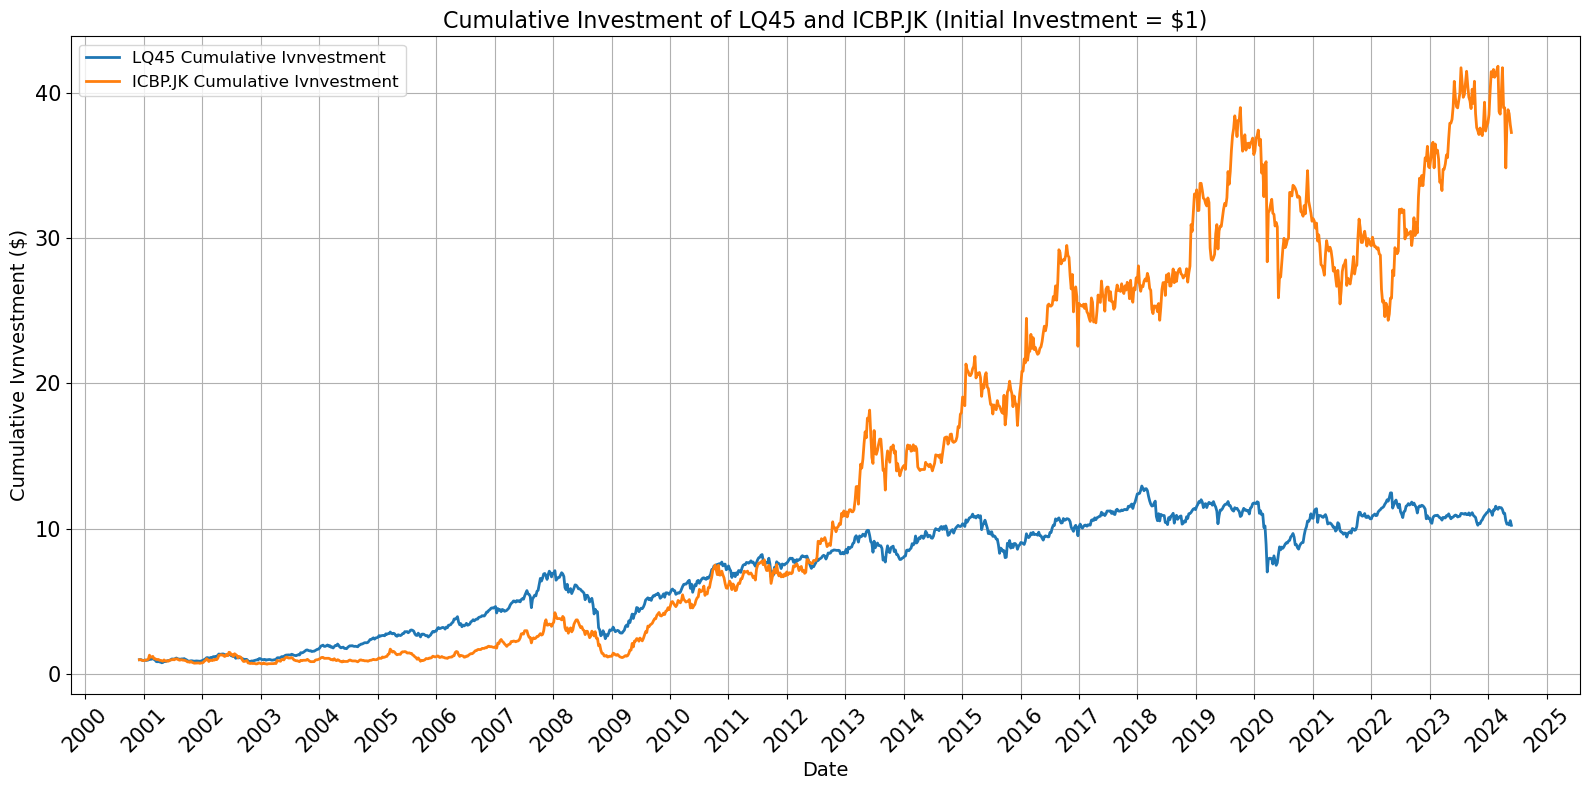

In [29]:
import matplotlib.dates as mdates

# Plot cumulative returns from $1
plt.figure(figsize=(16, 8))  # Increase figure size for better clarity

# Plot LQ45 and ICBP cumulative returns
plt.plot(cumulative_returns_LQ45, label='LQ45 Cumulative Ivnvestment', linewidth=2)
plt.plot(cumulative_returns_ICBP, label='ICBP.JK Cumulative Ivnvestment', linewidth=2)

# Set title and labels with increased font size
plt.title('Cumulative Investment of LQ45 and ICBP.JK (Initial Investment = $1)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Ivnvestment ($)', fontsize=14)

# Set x-ticks to show all years with increased font size
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set the major ticks to be every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the ticks to show only the year
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels and increase font size

# Increase the size of tick labels
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Show legend and grid
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()  

# Show plot
plt.show()


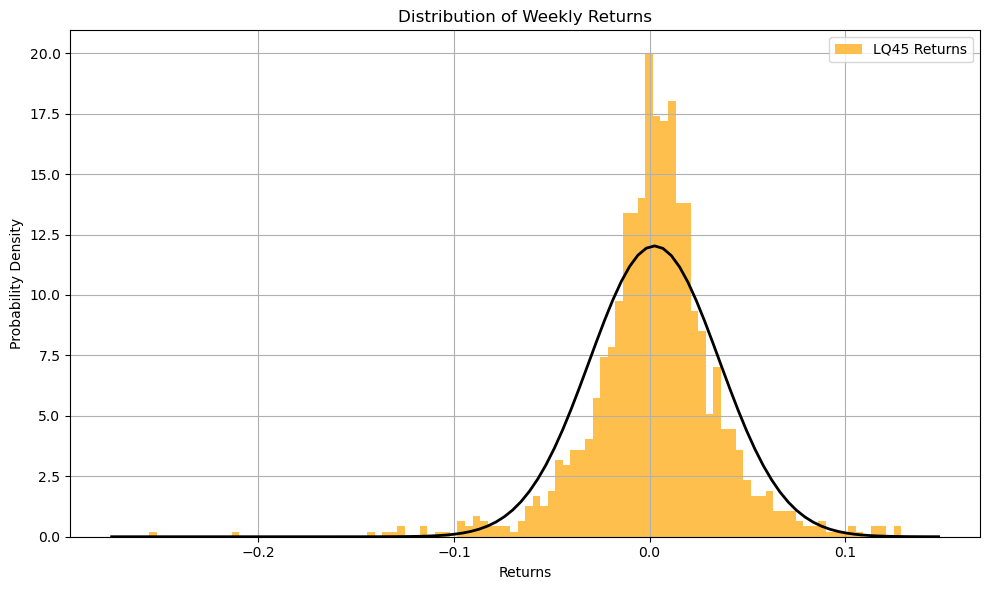

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the number of bins for the histogram
num_bins = 100

# Fit a normal distribution to the data
mu, sigma = norm.fit(LQ45_returns_weekly)

# Plot weekly returns as a bar graph
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(LQ45_returns_weekly, bins=num_bins, density=True, alpha=0.7, color='orange', label='LQ45 Returns')

# Plot the normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Distribution of Weekly Returns')
plt.xlabel('Returns')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

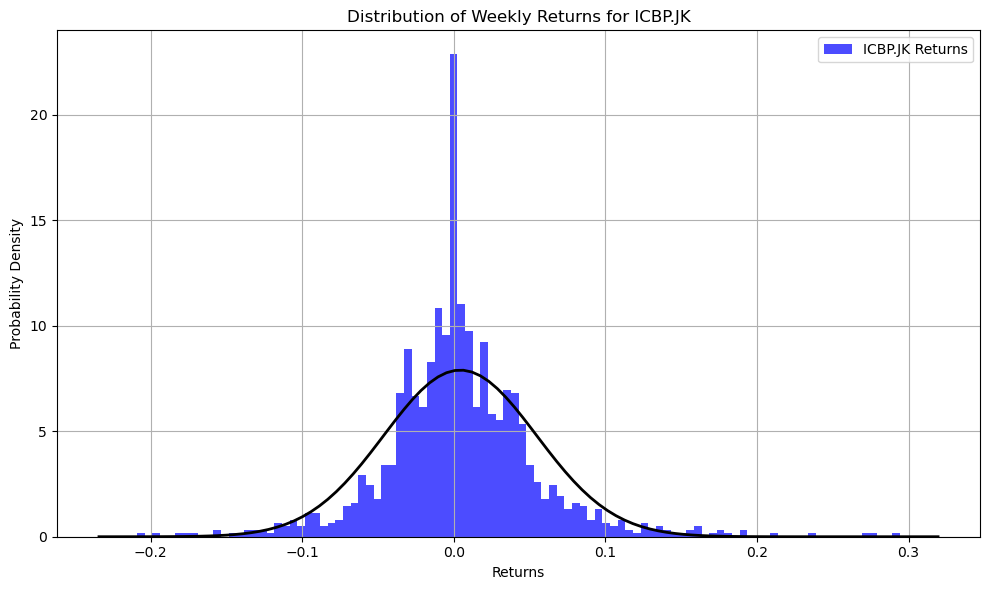

In [26]:
from scipy.stats import norm

# Define the number of bins for the histogram
num_bins = 100

# Fit a normal distribution to the data
mu, sigma = norm.fit(ICBP_returns_weekly)

# Plot weekly returns as a bar graph
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(ICBP_returns_weekly, bins=num_bins, density=True, alpha=0.7, color='blue', label='ICBP.JK Returns')

# Plot the normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Distribution of Weekly Returns for ICBP.JK')
plt.xlabel('Returns')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

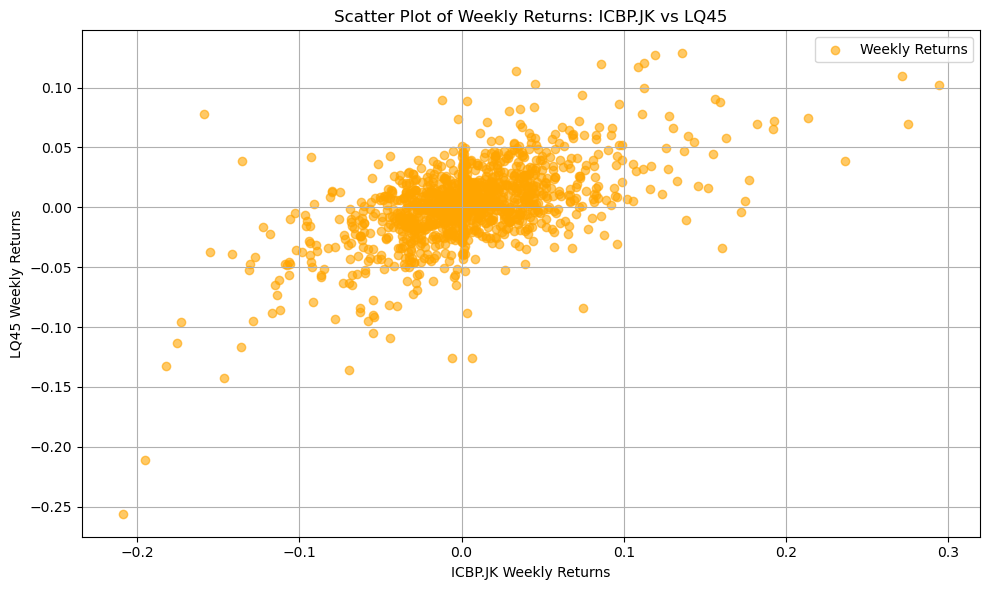

In [27]:
import matplotlib.pyplot as plt

# Align the indices of the two series
aligned_returns = pd.concat([ICBP_returns_weekly, LQ45_returns_weekly], axis=1)
aligned_returns.columns = ['ICBP', 'LQ45']
aligned_returns = aligned_returns.dropna()

# Create a scatter plot for the weekly returns of ICBP and LQ45
plt.figure(figsize=(10, 6))
plt.scatter(aligned_returns['ICBP'], aligned_returns['LQ45'], alpha=0.6, color='orange', label='Weekly Returns')

plt.title('Scatter Plot of Weekly Returns: ICBP.JK vs LQ45')
plt.xlabel('ICBP.JK Weekly Returns')
plt.ylabel('LQ45 Weekly Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# Combine the two DataFrames
weekly_returns_combined = pd.concat([LQ45_returns_weekly, ICBP_returns_weekly], axis=1)
weekly_returns_combined.columns = ['LQ45 Returns', 'ICBP Returns']

# Save the combined DataFrame to a CSV file
weekly_returns_combined.to_csv('../out/weekly_returns_combined.csv', index=True)  # index=True to include the date index in the CSV

print(f"Weekly returns combined and saved to {weekly_returns_combined}")

Weekly returns combined and saved to             LQ45 Returns  ICBP Returns
Date                                  
2000-12-03     -0.000443      0.000000
2000-12-10      0.015373      0.000891
2000-12-17     -0.026885     -0.029356
2000-12-24     -0.034690     -0.031250
2000-12-31      0.000000      0.000000
...                  ...           ...
2024-04-28     -0.023241      0.087907
2024-05-05      0.005772      0.024829
2024-05-12     -0.010960     -0.006912
2024-05-19      0.028931     -0.019680
2024-05-26     -0.030598     -0.014263

[1226 rows x 2 columns]


In [ ]:
##W2